# Курсовой проект

Разбор предыдущих ДЗ, показать удачные примеры. Важные моменты для обсуждения: 
- какой разделитель CSV стоит использовать по-умолчанию.
- какие имена таблиц стоит использовать для промежуточного хранения и какие пути
- поверка существования конечной таблицы vs drop create

#### Подготовка структуры и данных

- для начала скачиваем архив к ДЗ и смотрим содержимое

- из распакованной папки L8 поднимаем окружение через `docker-compose up -d`

- в результате должны быть подняты две БД Postgres - source с портом 54320 и target c портом 5433
- Airflow который отвечает на порту http://localhost:8082
- для подключения к Airflow импользуйте имя и пароль airflow

- в папке source_data находится ddl для создания таблиц. А также файлы с исходными данными для этих таблиц

Копируем данные из папки source_data в контейнер
>docker cp ./ddl.sql my_postgres1:/
<br>docker cp ./orderdetails.csv my_postgres1:/
<br>docker cp ./orders.csv my_postgres1:/
<br>docker cp ./products.csv my_postgres1:/
<br>docker cp ./productsuppl.csv my_postgres1:/
<br>docker cp ./suppliers.csv my_postgres1:/

Для работы с бд создадим в каждом инстансе базу
>docker exec -it my_postgres1 psql -U root -c "create database my_database"
<br>docker exec -it my_postgres2 psql -U root -c "create database my_database"

Создаем структуру в my_postgres1 и загружаем данные с помощью команды copy
>docker exec -it my_postgres1 psql my_database -f ddl.sql
<br>docker exec -it my_postgres1 psql my_database -c "\\copy products FROM '/products.csv' CSV DELIMITER '|' HEADER"
<br>docker exec -it my_postgres1 psql my_database -c "\\copy suppliers FROM '/suppliers.csv' CSV DELIMITER '|' HEADER"
<br>docker exec -it my_postgres1 psql my_database -c "\\copy productsuppl FROM '/productsuppl.csv' CSV DELIMITER '|' HEADER"
<br>docker exec -it my_postgres1 psql my_database -c "\\copy orders FROM '/orders.csv' CSV DELIMITER '|' HEADER"
<br>docker exec -it my_postgres1 psql my_database -c "\\copy orderdetails FROM '/orderdetails.csv' CSV DELIMITER '|' HEADER"

#### Что будет конечной целью курсового проекта

- dag который пересоздает (drop if exists) в целевой базе нужные таблицы (копирует схему из source), выполняется однократно.

В целевой базе таблицы создавать следует в отдельной схеме (stage)

Запуск большого кол-ва операторов sql можно вынести в отдельный файл и вызвать:<br>
>    create_tables_step = PostgresOperator(<br>
>      task_id="create_tables",<br>
>      postgres_conn_id="pg_target",<br>
>      sql="sql/my_file.sql"<br>
>      )

- dag который пересоздает в целевой базе таблицы для хранения данных в модели data vault, однократно

Продумайте структуру хранения для данных в терминах хабов, линков и их саттелитов. Подсказка - должно быть 3 хаба и 2 линка.
Сформируйте файл sql который создаст такую структуру.

Для хранения данных после преобразования используйте отдельную схему для таблиц (core)


- dag который копирует данные из исходной\source бд в целевую в stage, сохраняя формат

- dag который копирует данные из stage схемы в core схему (все манипуляции происходят на целевой\target БД)

Хабы будут иметь вид:

Таким образом мы поддерживаем уникальность сурогатного и бизнес ключа.

Сателлиты будут иметь вид:

#### Полезные ссылки

- чтение sql кода для формирования dag https://forum.astronomer.io/t/how-can-i-pass-sql-as-a-file-w-airflows-postgres-operator/355

- schedule_interval и его настройка

`* * * * * * 
 | | | | | | 
 | | | | | +-- Year              (range: 1900-3000) 
 | | | | +---- Day of the Week   (range: 1-7, 1 standing for Monday) 
 | | | +------ Month of the Year (range: 1-12) 
 | | +-------- Day of the Month  (range: 1-31) 
 | +---------- Hour              (range: 0-23) 
 +------------ Minute            (range: 0-59) `

 See more: http://www.nncron.ru/help/EN/working/cron-format.htm <br>
 Or datetime.timedelta<br>
 See more: https://docs.python.org/2/library/datetime.html#datetime.timedelta

 - Хорошие практики написания dag https://www.astronomer.io/guides/dag-best-practices

- Динамические зависимости между задачами https://www.astronomer.io/guides/managing-dependencies

- Использование авто-инкремента для генерации PK https://www.postgresqltutorial.com/postgresql-serial/

- Конфликт при вставке уже существующего ключа, обработка https://www.postgresqltutorial.com/postgresql-upsert/

- Вставка массива данных в таблицу update insert одновременно https://www.postgresql.org/message-id/attachment/23520/sql-merge.html

#### Структура в исходных таблицах и связи:

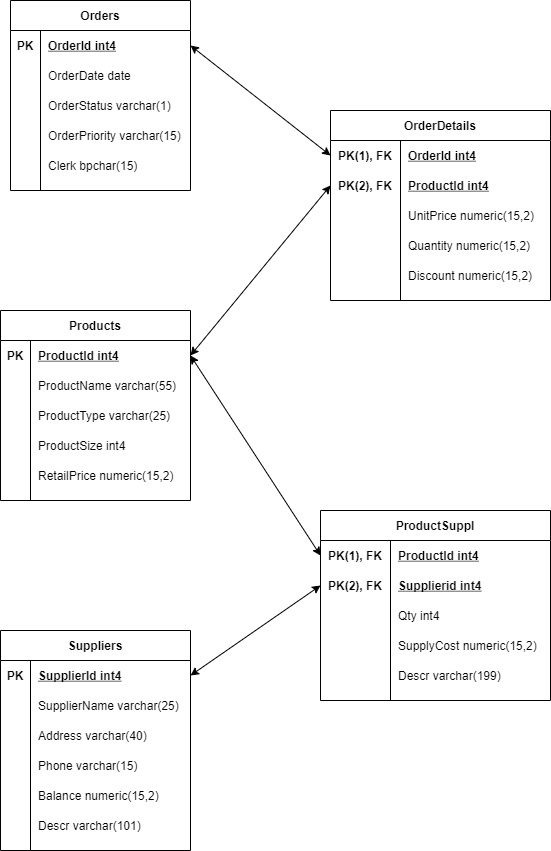